In [1]:
###################################################################
# Built-in modules ################################################
###################################################################
import sys
import os

sys.path.append("../../")

import numpy as np
import imp
import cv2
import os
import matplotlib.pyplot as plt
import gc

import math
import time
import glob

###################################################################
# Custom modules ##################################################
###################################################################

from components.matchers.NumbaPatchMatcher import Wrapper as m
from components.utils.SimpleProgressBar import SimpleProgressBar
from components.utils import utils as u
from components.utils import plot_utils as plu
from components.utils.CSVWriter2 import Wrapper as csv
from components.utils.Metrix import Wrapper as me

###################################################################
# Dataset specific modules#########################################
###################################################################

from components.utils import middlebury_utils as mbu


In [2]:
ROOT_PATH = os.path.join("..", "..")
EXPERIMENT_TITLE = "ALG_005_EXP_006-PatchMatch-MacLean_et_al-Numba-normlised_images"

INIT_METHOD = "maclean"
DATASET = "middlebury"

DATASET_FOLDER = os.path.join(ROOT_PATH, "datasets", DATASET)
LOG_FOLDER = os.path.join(ROOT_PATH, "experiments", "logs")
CSV_FILEPATH = os.path.join(LOG_FOLDER, EXPERIMENT_TITLE+".csv")
IMG_RES = "450X375"
PREPROCESSING_METHOD = "None"
KERNEL_SIZE = 1
KERNEL_SPEC = "None"

SCENES = ["teddy", "cones"]
SIZE=""
YEAR= 2003
EXP_PARAMS = dict()

#  Loading the dataset and visualising the results

['im2.png', 'im6.png', 'disp2.png', 'teddy_nonocc.png']
..\..\datasets\middlebury\middlebury_2003\teddy\im2.png
..\..\datasets\middlebury\middlebury_2003\teddy\im6.png
..\..\datasets\middlebury\middlebury_2003\teddy\disp2.png
..\..\datasets\middlebury\middlebury_2003\teddy\teddy_nonocc.png
['im2.png', 'im6.png', 'disp2.png', 'cones_nonocc.png']
..\..\datasets\middlebury\middlebury_2003\cones\im2.png
..\..\datasets\middlebury\middlebury_2003\cones\im6.png
..\..\datasets\middlebury\middlebury_2003\cones\disp2.png
..\..\datasets\middlebury\middlebury_2003\cones\cones_nonocc.png


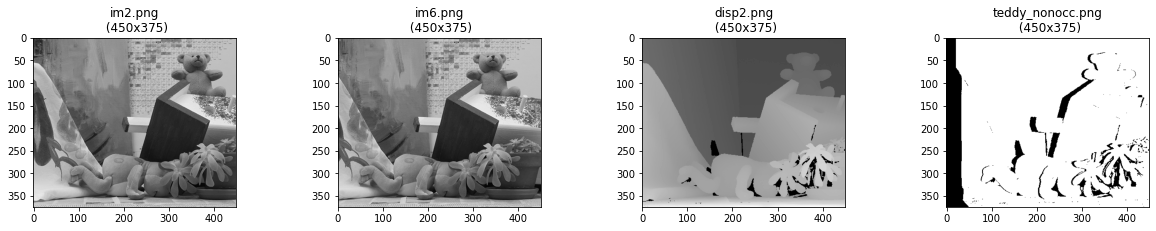

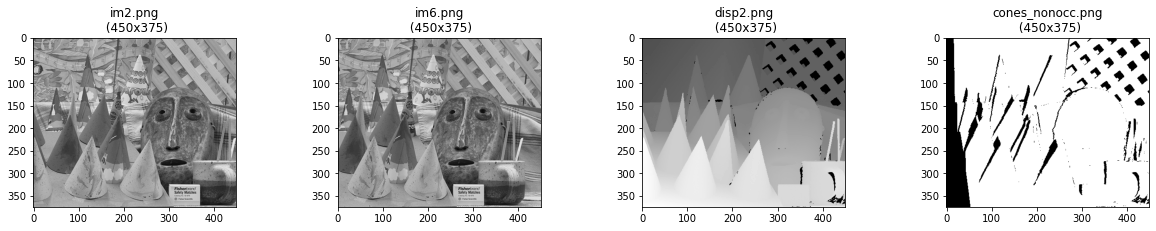

In [3]:
loaded_imgs_and_paths = list(mbu.get_images(DATASET_FOLDER, YEAR, scene) for scene in SCENES)

for im, path in loaded_imgs_and_paths:
    filenames = list(os.path.split(p)[-1] for p in path)
    plu.plot_images(im, filenames)

# Benchmarking and evaluation

In [4]:
###################################################################
# Initialising hyperparameters and matcher#####################
###################################################################

csv_logger = csv(CSV_FILEPATH, default_header=False)
csv_logger.set_header_function(csv_logger.get_header_v3)
csv_logger.write_csv_header()
csv_logger.set_line_function(csv.format_stereo_matching_results_v2)

MATCH = 30/255
GAP = -20/255
EGAP = -1/255


EXP_PARAMS = {"experiment_id":EXPERIMENT_TITLE, "match": MATCH,"gap":GAP,"egap":EGAP,\
                  "algo":str(m.__module__), "init_method":"default","dataset":DATASET,\
                  "preprocessing_method":"None","kernel_size":1,"kernel_spec":"None"}

Directory '..\..\experiments\logs' already exists.

In [5]:
###################################################################
# Matching ####################################################
###################################################################

results = []

EXP_PARAMS["init_method"] = "maclean_et_al"

patches = [
           np.ones((5,3)), np.ones((7,3)),
           np.ones((9,3)), np.ones((11,3)),
           np.ones((13,3)), np.ones((15,3))
          ]

matcher = m(MATCH, GAP, EGAP)
progress_bar = SimpleProgressBar.get_instance()

progress_counter = 1
steps_to_be_taken = len(SCENES)*len(patches)*7


SAVE_PATH  = os.path.join(ROOT_PATH, "experiments", "disparities", EXPERIMENT_TITLE)

saved_image_names = []
results = []

In [6]:
for match_value in range(10,40, 10):
    for p in patches:
        for i, scene in enumerate(SCENES):
            EXP_PARAMS["match"] = MATCH = match_value/255
            matcher = m(MATCH, GAP, EGAP)
            
            EXP_PARAMS["scene"] = scene
            EXP_PARAMS["image_filename"] = IMAGE_FILENAME = loaded_imgs_and_paths[i][1][0]
            EXP_PARAMS["img_res"] = "{0}x{1}".format(loaded_imgs_and_paths[i][0][1].shape[1], loaded_imgs_and_paths[i][0][1].shape[0])  
            EXP_PARAMS["kernel_size"] = "{0}x{1}".format(p.shape[0], p.shape[1])

            occ = loaded_imgs_and_paths[i][0][3]
            gt = loaded_imgs_and_paths[i][0][2]
            
            left = loaded_imgs_and_paths[i][0][0].astype(np.float64)/255
            right = loaded_imgs_and_paths[i][0][1].astype(np.float64)/255
            
            
            
            matcher.set_images(left, right)
            tic = time.time()

            matcher.configure_instance()
            matcher.set_filter(p)

            tic=time.time()

            x,raw_disp_map = matcher.test_pipeline()
            toc = time.time()

            EXP_PARAMS["runtime"] = toc-tic

            disp = raw_disp_map
            disp = 4*disp
            
            temp_path = u.save_disparity(SAVE_PATH, disp)
            saved_image_names.append(os.path.split(temp_path)[-1])
        
            EXP_PARAMS["image_filename"] = temp_path

            EXP_PARAMS["are_occlusions_errors"] = ARE_OCCLUSIONS_ERRORS = False

            EXP_PARAMS["bad1"], EXP_PARAMS["bad2"], EXP_PARAMS["bad4"], EXP_PARAMS["BAD8"], EXP_PARAMS["abs_error"], EXP_PARAMS["mse"], EXP_PARAMS["avg"], EXP_PARAMS["eucledian"] =\
            BAD1, BAD2, BAD4, BAD8, ABS_ERR, MSE, AVG, EUCLEDIAN = me.evaluate_over_all(disp, gt, occ, occlusions_counted_in_errors = ARE_OCCLUSIONS_ERRORS)

            csv_logger.append_new_sm_results(EXP_PARAMS, selected_keys=csv.get_header_v3())

            EXP_PARAMS["are_occlusions_errors"]  = True
            EXP_PARAMS["bad1"], EXP_PARAMS["bad2"], EXP_PARAMS["bad4"], EXP_PARAMS["BAD8"], EXP_PARAMS["abs_error"], EXP_PARAMS["mse"], EXP_PARAMS["avg"], EXP_PARAMS["eucledian"] =\
            BAD1, BAD2, BAD4, BAD8, ABS_ERR, MSE, AVG, EUCLEDIAN = me.evaluate_over_all(disp, gt, gt, occlusions_counted_in_errors = ARE_OCCLUSIONS_ERRORS)

            csv_logger.append_new_sm_results(EXP_PARAMS, selected_keys=csv.get_header_v3())
            results.append(disp)

            progress_bar.progress_bar(progress_counter, steps_to_be_taken, header= "Experiment on patch sizes in progress: ", progress_bar_steps=40)
            progress_counter+=1

Experiment on patch sizes in progress:  [>>>>>>>>>>>>>>>>>-----------------------] 42.86 % completed: 36 / 84 steps

In [7]:
SAVE_PATH  = os.path.join(ROOT_PATH, "experiments", "disparities", EXPERIMENT_TITLE)
saved_image_names = []
for result in results:
    temp_path = u.save_disparity(SAVE_PATH, result)
    saved_image_names.append(os.path.split(temp_path)[-1])

In [3]:
import pandas as pd
experiment_log = pd.read_csv(CSV_FILEPATH)
experiment_log.sort_values(by="bad1", inplace=True) 
experiment_log.head(30)

,experiment_id,match,gap,egap,algo,init_method,dataset,scene,image_filename,img_res,...,are_occlusions_errors,abs_error,mse,avg,eucledian,bad1,bad2,bad4,bad8,runtime
34,ALG_005_EXP_006-PatchMatch-MacLean_et_al-Numba...,0.078431,-0.078431,-0.003922,components.matchers.NumbaPatchMatcher,maclean_et_al,middlebury,cones,..\..\experiments\disparities\ALG_005_EXP_006-...,450x375,...,False,1042316.0,758.250712,7.242027,10446.625867,0.373095,0.183309,0.099468,0.079742,53.903611
38,ALG_005_EXP_006-PatchMatch-MacLean_et_al-Numba...,0.078431,-0.078431,-0.003922,components.matchers.NumbaPatchMatcher,maclean_et_al,middlebury,cones,..\..\experiments\disparities\ALG_005_EXP_006-...,450x375,...,False,1056206.0,773.412504,7.338535,10550.552971,0.373491,0.184115,0.100989,0.080910,70.010701
30,ALG_005_EXP_006-PatchMatch-MacLean_et_al-Numba...,0.078431,-0.078431,-0.003922,components.matchers.NumbaPatchMatcher,maclean_et_al,middlebury,cones,..\..\experiments\disparities\ALG_005_EXP_006-...,450x375,...,False,1036780.0,748.462849,7.203563,10378.981838,0.375929,0.186200,0.100336,0.079520,59.334179
42,ALG_005_EXP_006-PatchMatch-MacLean_et_al-Numba...,0.078431,-0.078431,-0.003922,components.matchers.NumbaPatchMatcher,maclean_et_al,middlebury,cones,..\..\experiments\disparities\ALG_005_EXP_006-...,450x375,...,False,1072864.0,782.379278,7.454275,10611.537118,0.376756,0.188423,0.104255,0.082647,59.720530
46,ALG_005_EXP_006-PatchMatch-MacLean_et_al-Numba...,0.078431,-0.078431,-0.003922,components.matchers.NumbaPatchMatcher,maclean_et_al,middlebury,cones,..\..\experiments\disparities\ALG_005_EXP_006-...,450x375,...,False,1097128.0,802.445868,7.622862,10746.758767,0.378264,0.190431,0.107326,0.085606,73.141874
26,ALG_005_EXP_006-PatchMatch-MacLean_et_al-Numba...,0.078431,-0.078431,-0.003922,components.matchers.NumbaPatchMatcher,maclean_et_al,middlebury,cones,..\..\experiments\disparities\ALG_005_EXP_006-...,450x375,...,False,1044794.0,748.635549,7.259244,10380.179189,0.379091,0.190230,0.102851,0.081542,46.667363
58,ALG_005_EXP_006-PatchMatch-MacLean_et_al-Numba...,0.117647,-0.078431,-0.003922,components.matchers.NumbaPatchMatcher,maclean_et_al,middlebury,cones,..\..\experiments\disparities\ALG_005_EXP_006-...,450x375,...,False,1000762.0,684.353404,6.953309,9924.527596,0.383239,0.196406,0.106374,0.083272,55.635111
62,ALG_005_EXP_006-PatchMatch-MacLean_et_al-Numba...,0.117647,-0.078431,-0.003922,components.matchers.NumbaPatchMatcher,maclean_et_al,middlebury,cones,..\..\experiments\disparities\ALG_005_EXP_006-...,450x375,...,False,1009080.0,687.612690,7.011103,9948.132689,0.384392,0.198310,0.108792,0.085210,68.528898
54,ALG_005_EXP_006-PatchMatch-MacLean_et_al-Numba...,0.117647,-0.078431,-0.003922,components.matchers.NumbaPatchMatcher,maclean_et_al,middlebury,cones,..\..\experiments\disparities\ALG_005_EXP_006-...,450x375,...,False,997024.0,678.332365,6.927338,9880.772439,0.385128,0.198276,0.108097,0.083849,56.515818
66,ALG_005_EXP_006-PatchMatch-MacLean_et_al-Numba...,0.117647,-0.078431,-0.003922,components.matchers.NumbaPatchMatcher,maclean_et_al,middlebury,cones,..\..\experiments\disparities\ALG_005_EXP_006-...,450x375,...,False,1019200.0,692.533997,7.081417,9983.669065,0.385934,0.199853,0.110050,0.086676,50.517020


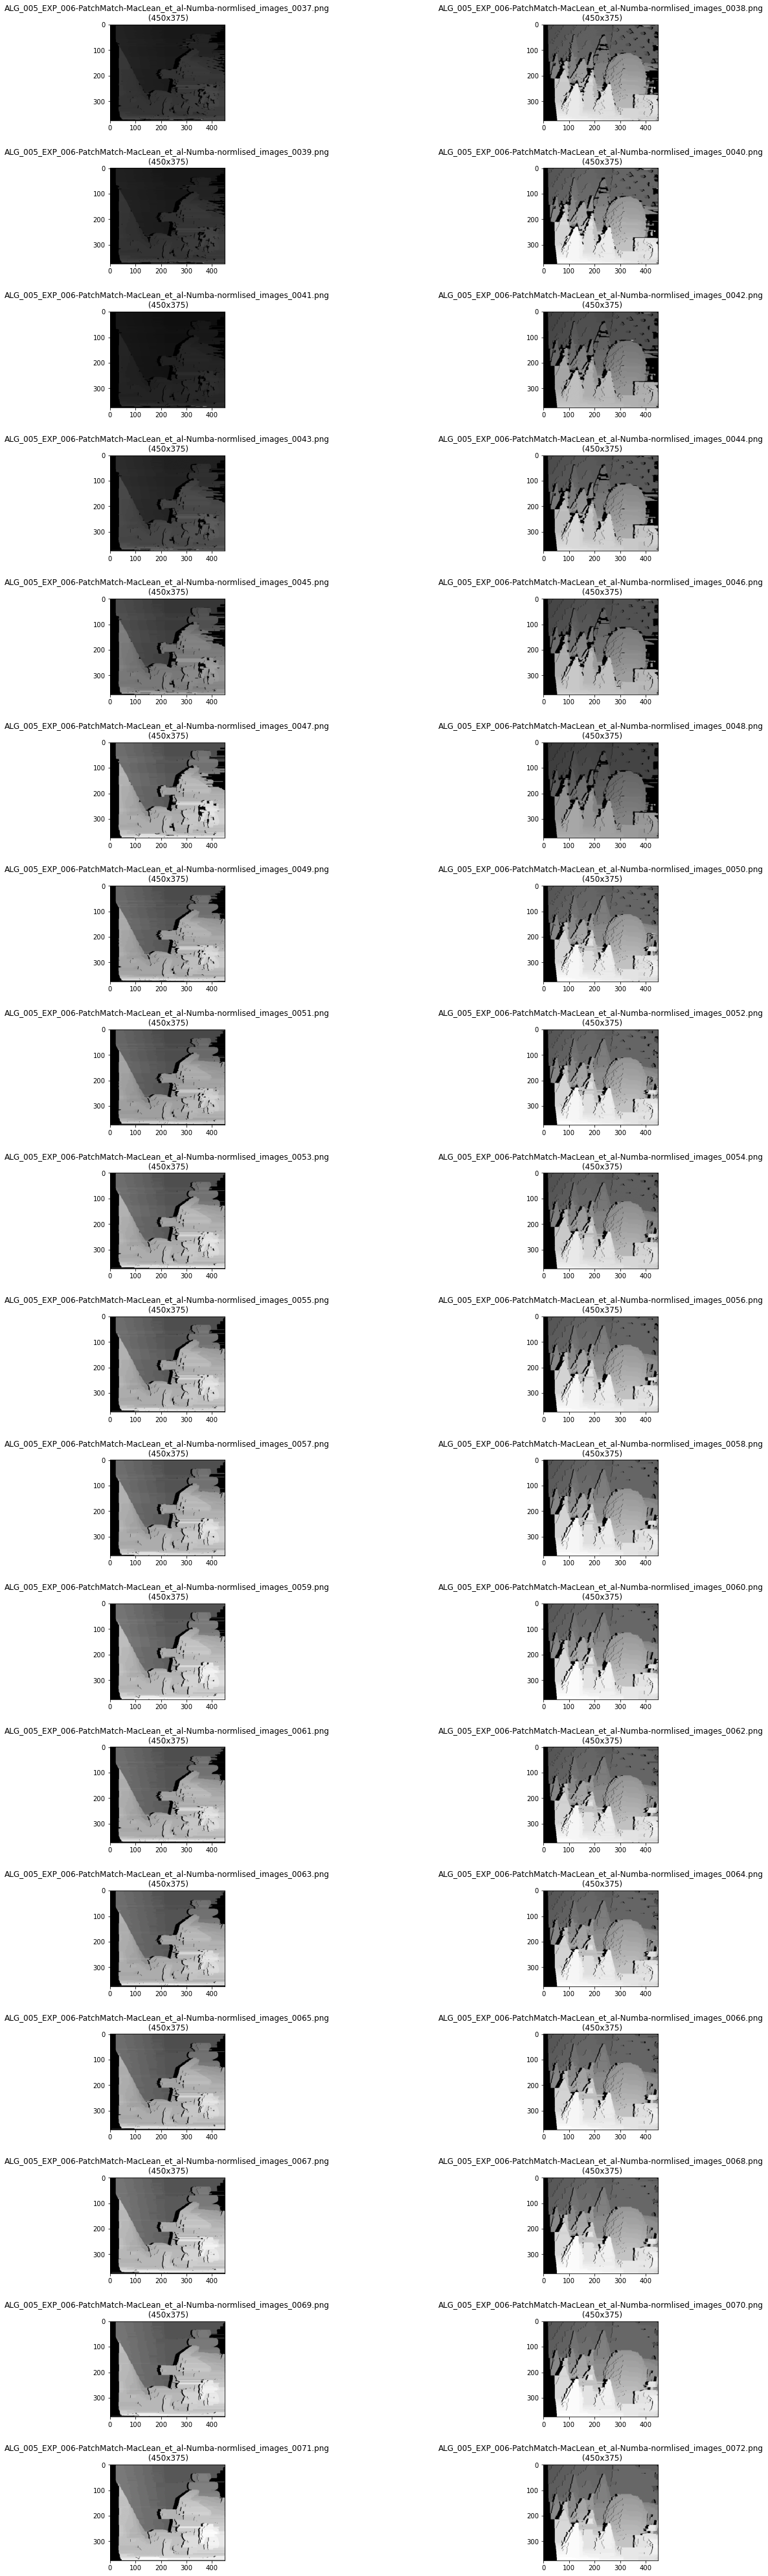

In [9]:
plu.plot_images(results, saved_image_names, ncols=2)